# Исследование бизнес показателей сервиса Яндекс.Афиша. 



Целью проекта является анализ посещаемости, доходов и расходов сервиса Яндекс.Афиша, в результате которого попытаемся выявить невыгодные источники трафика, определим перспективные когорты, сделаем выводы о финансовом положении сервиса и составим рекомендации о перераспределении бюджета для умножения прибыли.

## Содержание
1. [Изучение общей информации.](#paragraph1)
2. [Предобработка данных.](#paragraph2)
3. [Расчет метрик.](#paragraph3)
    1. [Продуктовые метрики](#subparagraph1)
    2. [Метрики электронной коммерции](#subparagraph2)
    3. [Маркетинговые метрики](#subparagraph3)
4. [Вывод](#paragraph4)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
try:
    visits = pd.read_csv('/datasets/visits_log.csv')
    costs = pd.read_csv('/datasets/costs.csv')
    orders = pd.read_csv('/datasets/orders_log.csv')
except FileNotFoundError:
    visits = pd.read_csv('visits_log.csv')
    costs = pd.read_csv('costs.csv')
    orders = pd.read_csv('orders_log.csv')

## Изучение общей информации.<a name="paragraph1"></a>

In [4]:
list_of_data = [visits, costs, orders]
for i in list_of_data:
    display(i.info())
    display(i.sample(5))
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Device,End Ts,Source Id,Start Ts,Uid
13199,desktop,2017-12-01 22:41:00,3,2017-12-01 22:05:00,13040399607084048109
93942,desktop,2018-03-09 11:44:00,4,2018-03-09 11:39:00,15800136906393231506
272926,desktop,2017-08-26 15:00:00,5,2017-08-26 14:55:00,610581513506748990
5575,desktop,2017-10-03 17:29:00,5,2017-10-03 17:18:00,15353735381794552960
25510,desktop,2018-03-11 20:42:00,4,2018-03-11 20:41:00,1248638664572397499



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

,source_id,dt,costs
1375,4,2018-03-14,140.16
1219,4,2017-10-09,263.95
1121,4,2017-07-03,54.69
419,2,2017-07-27,53.35
907,3,2017-11-29,654.18



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,Buy Ts,Revenue,Uid
23554,2017-12-12 12:43:00,1.22,15017766462817232278
36469,2018-02-22 19:12:00,4.89,14845371677675079908
1878,2017-06-23 19:31:00,3.67,13975932056717210136
3477,2017-07-15 14:26:00,1.83,13888745432979765063
1705,2017-06-20 21:39:00,2.44,8277279839277675811


## Предобработка данных.<a name="paragraph2"></a>

Приведение названий колонок к нижнему регистру.

In [5]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

Приведение типов данных к временному. Остальные типы соответствуют.

In [6]:
display(visits.columns) #выведем названия колонок
display(costs.columns)
display(orders.columns)

Index(['device', 'end ts', 'source id', 'start ts', 'uid'], dtype='object')

Index(['source_id', 'dt', 'costs'], dtype='object')

Index(['buy ts', 'revenue', 'uid'], dtype='object')

In [7]:
visits['end ts'] = pd.to_datetime(visits['end ts'], format = '%Y-%m-%d %H:%M:%S')
visits['start ts'] = pd.to_datetime(visits['start ts'], format = '%Y-%m-%d %H:%M:%S')
orders['buy ts'] = pd.to_datetime(orders['buy ts'], format = '%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d')

In [8]:
visits.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end ts       359400 non-null datetime64[ns]
source id    359400 non-null int64
start ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [9]:
visits[visits['start ts'] > visits['end ts']]['uid'].count()

2

In [10]:
orders[orders['revenue']<=0]['uid'].count()

51

## Рассчёт метрик<a name="paragraph3"></a>

### Продуктовые метрики. <a name="subparagraph1"></a>

#### DAU, WAU и MAU. 

In [11]:
visits['date'] = visits['start ts'].dt.date
visits['week'] = visits['start ts'].dt.week
visits['month'] = visits['start ts'].dt.month
visits['year'] = visits['start ts'].dt.year

In [12]:
DAU = visits.groupby('date').agg({'uid':'nunique'})
DAU_total = int(DAU.mean())
print('Среднее количество уникальных посетителей в день:', DAU_total)

Среднее количество уникальных посетителей в день: 907


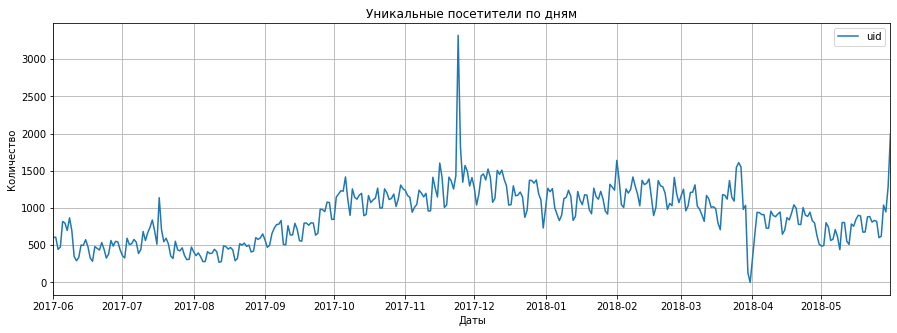

In [13]:
DAU.plot(figsize=(15, 5), grid=True)
plt.xlabel('Даты') 
plt.ylabel('Количество')
plt.title('Уникальные посетители по дням')
plt.show()

In [14]:
DAU.sort_values(by='uid', ascending=False).head(1) #пик

,uid
date,
2017-11-24,3319


In [15]:
DAU.sort_values(by='uid', ascending=True).head(1) #низшая точка

,uid
date,
2018-03-31,1


Пиковое значение приходится на знаменитый день распродаж - Черную пятницу. Также есть день с наименьшим показателем в всего один день 31.03.2018. Стоит разобраться в причинах.

In [16]:
WAU = visits.groupby(['year', 'week']).agg({'uid':'nunique'})
WAU_total = int(WAU.mean())
print('Среднее количество уникальных посетителей в неделю:', WAU_total)

Среднее количество уникальных посетителей в неделю: 5716


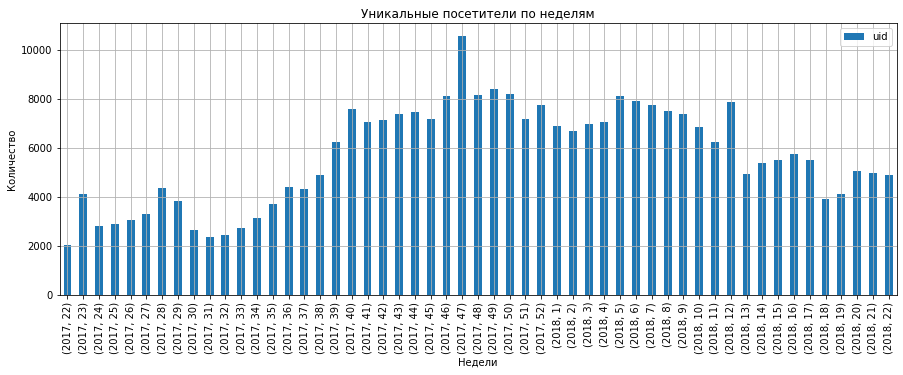

In [17]:
WAU.plot(kind='bar', figsize=(15, 5), grid=True)
plt.title('Уникальные посетители по неделям'),
plt.xlabel('Недели'), 
plt.ylabel('Количество')
plt.show()

Пик посещений приходится на 47 неделю. На ней проводится черная пятница - день большой распродажи, отсюда такой ажиотаж.

In [18]:
MAU = visits.groupby(['year', 'month']).agg({'uid':'nunique'})
MAU_total = int(WAU.mean())
print('Среднее количество уникальных посетителей в месяц:', MAU_total)

Среднее количество уникальных посетителей в месяц: 5716


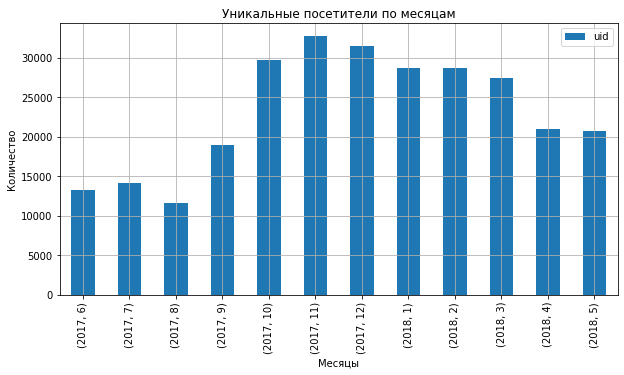

In [19]:
MAU.plot(kind='bar', figsize=(10, 5), grid=True)
plt.title('Уникальные посетители по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество')
plt.show()

Большая часть визитов на сервис происходит в осенне-зимний период. В летние месяцы наблюдаетя спад. 
Вероятно из-за периодов отпусков у ползователей отпадает необходимость выбирать мериприятия для посещения. А с наступлением холодного времени, количство посетителей увеличивается в связи с желанием провести интересно время в теплых помещениях.

#### Cколько раз за день пользователи в среднем заходят на сайт.

In [20]:
visits_per_user = visits.groupby('date').agg({'uid':['count','nunique']})

In [21]:
visits_per_user.columns = ['n_visits', 'n_users']
visits_per_user['visits_per_user'] = visits_per_user['n_visits'] / visits_per_user['n_users']

In [22]:
print('Среднее количество посещений на одного пользователя в день', visits_per_user['visits_per_user'].mean())

Среднее количество посещений на одного пользователя в день 1.082169644003972


#### Сколько времени пользователи проводят на сайте.

In [23]:
visits['duration'] = (visits['end ts'] - visits['start ts']).dt.seconds

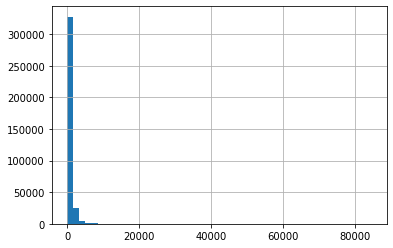

In [24]:
visits['duration'].hist(bins=50)

График распределения демонстрирует, что большая часть значений сосредоточена у левой границы. Медиану или среднее брать неверно, возьмем самое частое значение с помощью метода .mode()

In [25]:
print('Средняя продолжительность визита на cайт', int(visits['duration'].mode()), 'секунд')

Средняя продолжительность визита на cайт 60 секунд


#### Рассчитаем Retention Rate.
Сколько посетителей сайта возращаются в последующие месяцы

In [26]:
visits.head(10)

,device,end ts,source id,start ts,uid,date,week,month,year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017,0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,9,2017,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018-01-30,5,1,2018,3360
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,2017-11-05,44,11,2017,60
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,2017-07-19,29,7,2017,180
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,2017-11-08,45,11,2017,60


In [27]:
first_visit_date = visits.groupby('uid')['start ts'].min()

In [28]:
first_visit_date

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: start ts, Length: 228169, dtype: datetime64[ns]

In [29]:
first_visit_date.name = 'first_visit_date'

In [30]:
visits = visits.join(first_visit_date, on='uid')

In [31]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start ts'].astype('datetime64[M]')

In [32]:
# выделяем когорты по месяцам
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [33]:
cohorts = visits.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts

,first_visit_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


In [34]:
# считаем количество пользователей в нулевом lifetime каждой когорты
initial_uid_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_uid_count = initial_uid_count.rename(columns={'uid':'cohort_uids'})
initial_uid_count

,first_visit_month,cohort_uids
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [35]:
cohorts = cohorts.merge(initial_uid_count, on='first_visit_month') # приесодиняем

In [36]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_uids']

In [37]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


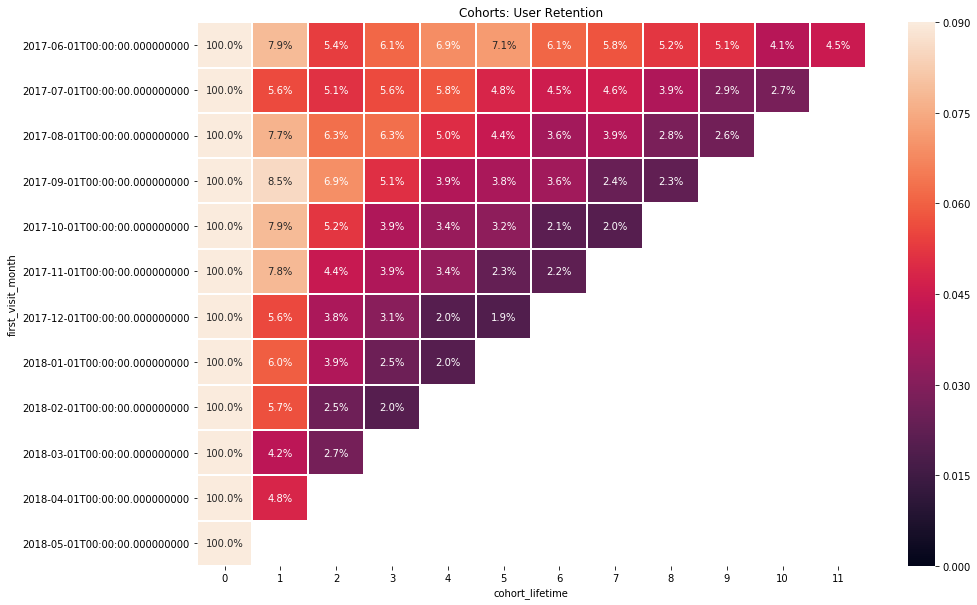

In [38]:
plt.figure(figsize=(15, 10))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', vmin=0.0, vmax=0.09)

In [39]:
second_cohort = cohorts[cohorts['cohort_lifetime'] == 1]
avg_second_cohort_retention = second_cohort['retention'].mean()
print('Средний Retention Rate на второй месяц «жизни» когорт', '{:.2%}'.format(avg_second_cohort_retention))

Средний Retention Rate на второй месяц «жизни» когорт 6.52%


Судя по графику, частота посещений сервиса ежемесячно снижается. На второй месяц возвращается на сайт всего 6,52% от изначаного количества польвователей. Далее показатели падают и, в зависимости от когорт, колеблются в районе 4-2%. Стоит рассмотреть варианты и сценарии возвращения пользователей. Для этого нужно проанализировать первую когорту, т.к. у нее самые высокие показатели удержания.

## Метрики электронной коммерции <a name="subparagraph3"></a>

### Сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

In [40]:
first_visit = visits.groupby('uid')['first_visit_date'].min().reset_index()

In [41]:
first_order = orders.groupby('uid')['buy ts'].min().reset_index()
first_order = first_order.rename(columns={'buy ts': 'first_order_date'})

In [42]:
visits_with_orders = first_visit.merge(first_order, on='uid')

In [43]:
visits_with_orders['time_for_order'] = visits_with_orders['first_order_date'] - visits_with_orders['first_visit_date']
visits_with_orders['time_for_order_days'] = visits_with_orders['time_for_order'] / np.timedelta64(1, 'D') # будем измерять в днях
avg_time_for_order = visits_with_orders['time_for_order_days'].mean()

In [44]:
print('Среднее время до первой покупки {:.1f} дней'.format(avg_time_for_order))

Среднее время до первой покупки 16.9 дней


Нашли среднее, но посмотрим на общее распределение. 

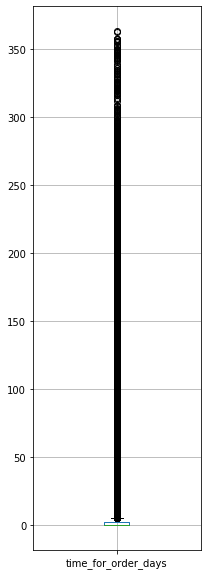

In [45]:
visits_with_orders.boxplot('time_for_order_days', figsize=(3, 10))

In [46]:
visits_with_orders['time_for_order'].describe()

count                      36523
mean     16 days 21:40:10.550064
std      47 days 01:44:46.481416
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:00
max            363 days 07:04:00
Name: time_for_order, dtype: object

25% покупателей покупателей заходят на сайт явно с целью покупки. От захода до оплаты проходит менее 5 минут.
Более половины всех покупателей справляются со своими целями за 16 минут. 

Самое частое время, которое у посетителей уходит от момента захода до покупки найдем ниже.

In [47]:
visits_with_orders['time_for_order'].mode()

0   00:01:00
dtype: timedelta64[ns]

Всего одна минута. 

**Вывод**

В целом покупателей можно разделить на две категории: быстрых и медленных. Быстрые посещают сервис с конкретной целью покупки, что демонтрируем время - около 16 минут. Это большая часть людей, а точнее ровно половина от всех покупателей из выборки.
Медленные же могут присматриваться и выбирать в течение дней и месяцев, прицениваясь или ожидая анонса на нужное событие. 

### Среднее количество покупок на одного покупателя за 6 месяцев. 

In [48]:
orders.head()

,buy ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Выделим первый месяц покупки. 

In [49]:
first_orders_date = orders.groupby('uid')['buy ts'].min()
first_orders_date.name = 'first_orders_date'

In [50]:
orders = orders.join(first_orders_date, on='uid')

In [51]:
orders['first_orders_month'] = orders['first_orders_date'].astype('datetime64[M]')
orders['orders_month'] = orders['buy ts'].astype('datetime64[M]')

Сформируем когорты.

In [52]:
orders['lifetime'] = orders['orders_month'] - orders['first_orders_month']
orders['lifetime'] = orders['lifetime'] / np.timedelta64(1, 'M')
orders['lifetime'] = orders['lifetime'].round().astype('int')

In [53]:
order_cohorts = orders.groupby(['first_orders_month', 'lifetime']).agg({'uid':['count', 'nunique']}).reset_index()

In [54]:
order_cohorts.columns = ['first_orders_month', 'lifetime', 'orders_sum', 'orders_count']

In [55]:
order_cohorts['order_per_buyer'] = order_cohorts['orders_sum'] / order_cohorts['orders_count']

Соберем данные в сводную таблицу и расчитываем среднее количество покупок на одного покупателя по месяцам жизни когорт.

In [56]:
order_cohorts_pivot = order_cohorts.pivot_table(index='first_orders_month', columns='lifetime', values='order_per_buyer', aggfunc='mean')
order_cohorts_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


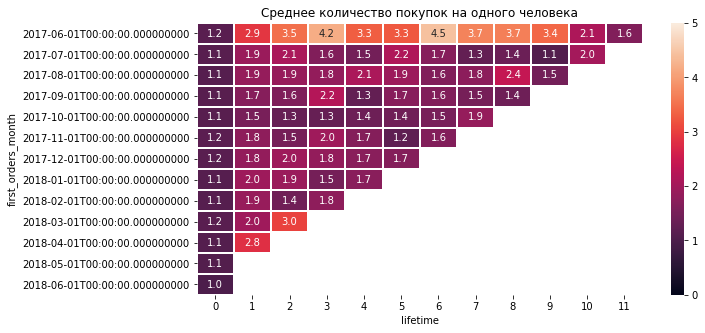

In [57]:
plt.figure(figsize=(10, 5))
plt.title('Среднее количество покупок на одного человека')
sns.heatmap(order_cohorts_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='white', vmin=0.0, vmax=5)

Возьмем только те когорты которые прожили полные 6 месяцев и посчитаем среднее по их первому полугодию. Это будут когорты с июня по декабрь.

In [58]:
order_cohorts_query = order_cohorts[(order_cohorts['first_orders_month'] < '2018-01-01') & (order_cohorts['lifetime'] < 6)]
avg_order_per_buyer = order_cohorts_query['order_per_buyer'].mean()
print('Cреднее количество покупок на одного покупателя {:.2f}'.format(avg_order_per_buyer))

Cреднее количество покупок на одного покупателя 1.83


Хороший показатель, но есть куда стремиться. Первая когорта это отлично показывает.

### Рассчитаем средний чек.

Разворачивать график среднего чека буду по календарным месяцам, а не по месяцу жизни когорты, потому что необходимо увидеть какой месяц более прибыльный в абсолюте.

In [59]:
revenue_cohorts = orders.groupby(['first_orders_month', 'orders_month']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()

In [60]:
revenue_cohorts['revenue_per_user'] = revenue_cohorts['revenue'] / revenue_cohorts['uid']

In [61]:
revenue_cohorts['first_orders_month'] = revenue_cohorts['first_orders_month'].astype('datetime64[M]')

In [62]:
revenue_cohorts_pivot = revenue_cohorts.pivot_table(index='first_orders_month', columns='orders_month', values='revenue_per_user', aggfunc='mean')

In [63]:
revenue_cohorts_pivot

orders_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_orders_month,,,,,,,,,,,,,
2017-06-01,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151,NaN
2017-07-01,NaN,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08-01,NaN,NaN,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN
2017-09-01,NaN,NaN,NaN,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN
2017-10-01,NaN,NaN,NaN,NaN,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.135636,8.721228,12.365542,11.199767,4.699556,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.156987,8.610000,4.942414,6.941026,NaN


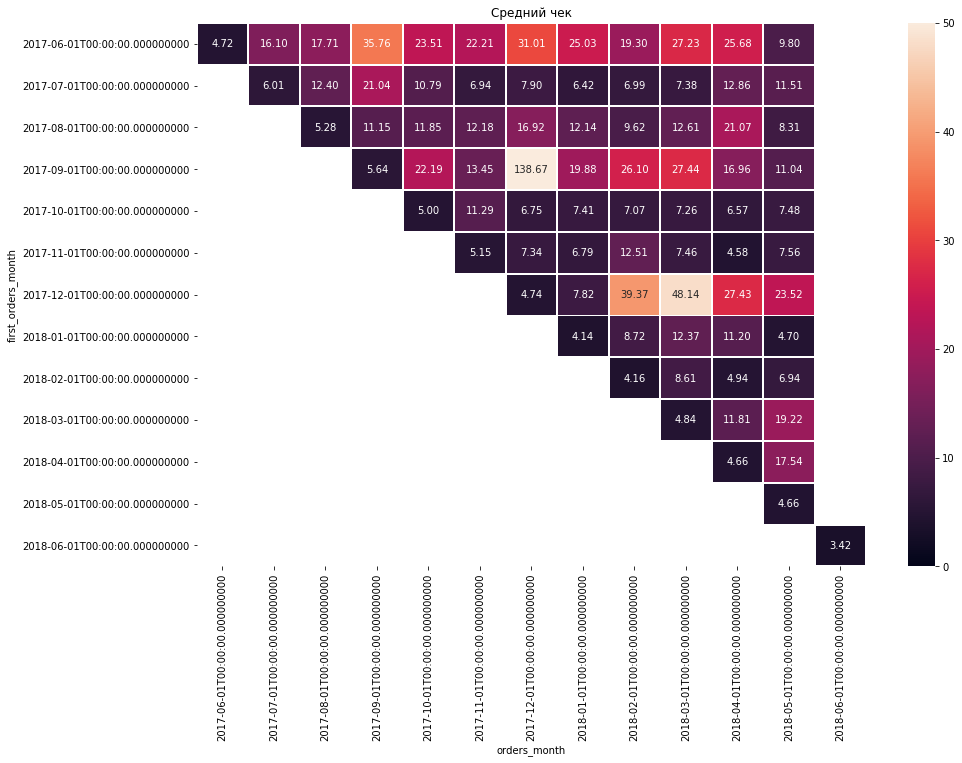

In [64]:
plt.figure(figsize=(15, 10))
plt.title('Средний чек')
sns.heatmap(revenue_cohorts_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0.0, vmax=50)
plt.show()

Самые высокие показатели среднего чека у первой когорты 2017-06-01 покупателей на протяжении всей жизни.Эта когорта точно перспективная.
Также хорошие показатели у когорты 2017-09-01, особенно средний чек за декабрь - абсолютный лидер.
И стои отметить декбрьскую когорту 2017-12-01, в которой тоже высокие показатели среднего чека.

### Как меняется во времени LTV на покупателя по когортам. 

Сгруппируем заказы по когортам и возрасту когорты. Выручку сложим.

In [65]:
ltv_cohorts = orders.groupby(['first_orders_month', 'lifetime']).agg({'revenue':'sum'}).reset_index()
ltv_cohorts

,first_orders_month,lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58
...,...,...,...
74,2018-03-01,2,1114.87
75,2018-04-01,0,10600.69
76,2018-04-01,1,1209.92
77,2018-05-01,0,13925.76


Выделим размеры когорт.

In [66]:
cohort_sizes = orders.groupby('first_orders_month').agg({'uid': 'nunique'})
cohort_sizes

,uid
first_orders_month,
2017-06-01,2023
2017-07-01,1923
2017-08-01,1370
2017-09-01,2581
2017-10-01,4340
2017-11-01,4081
2017-12-01,4383
2018-01-01,3373
2018-02-01,3651


In [67]:
ltv_cohorts = ltv_cohorts.join(cohort_sizes, on='first_orders_month')

Счиатем LTV. Делим доход от покупателей в когортах и месяцах жизни на количество покупателей в когорте

In [68]:
ltv_cohorts['ltv'] = ltv_cohorts['revenue'] / ltv_cohorts['uid']
ltv_cohorts

,first_orders_month,lifetime,revenue,uid,ltv
0,2017-06-01,0,9557.49,2023,4.724414
1,2017-06-01,1,981.82,2023,0.485329
2,2017-06-01,2,885.34,2023,0.437637
3,2017-06-01,3,1931.30,2023,0.954671
4,2017-06-01,4,2068.58,2023,1.022531
...,...,...,...,...,...
74,2018-03-01,2,1114.87,3533,0.315559
75,2018-04-01,0,10600.69,2276,4.657597
76,2018-04-01,1,1209.92,2276,0.531599
77,2018-05-01,0,13925.76,2988,4.660562


Как меняется во времени LTV на покупателя по когортам.

In [69]:
report_1 = ltv_cohorts.pivot_table(index='first_orders_month', columns='lifetime', values='ltv', aggfunc='mean')
report_1.cumsum(axis=1)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


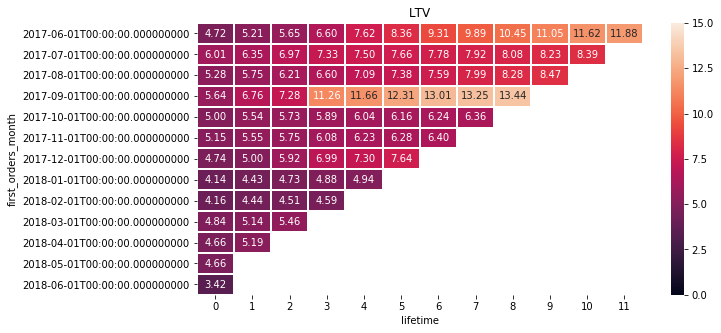

In [70]:
plt.figure(figsize=(10, 5))
plt.title('LTV')
sns.heatmap(report_1.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0.0, vmax=15)
plt.show()

Сделаем срез и возьмем только те когорты, которые прожили не менее 6 месяцев.

In [71]:
ltv_cohorts_query = ltv_cohorts[(ltv_cohorts['first_orders_month'] < '2018-01-01') & (ltv_cohorts['lifetime'] < 6)]

### Рассчитаем средний LTV по когортам за 6 месяцев.

In [72]:
avg_ltv_cohorts_query = ltv_cohorts_query.groupby('first_orders_month')['ltv'].sum()
avg_ltv_cohorts_query #  сумма LTV на одного пользователя для каждой из 7 когорт 

first_orders_month
2017-06-01     8.360084
2017-07-01     7.660775
2017-08-01     7.375861
2017-09-01    12.306463
2017-10-01     6.159956
2017-11-01     6.280316
2017-12-01     7.639913
Name: ltv, dtype: float64

In [73]:
print('Cредний LTV по когортам за 6 месяцев {:.2f}'.format(avg_ltv_cohorts_query.mean()))

Cредний LTV по когортам за 6 месяцев 7.97


**Вывод**

Судя по тепловой карте, у когорт разный темп наколения LTV. Так сентябрьская когорта уже на 4й месяц жизни показывает очень хорошие результаты, тогда как большинство других когорт не демонтрируют такого прироста и к 8 месяцу. Сентябрьская и декабрьская когорты выглядит перспективно.

Взяв период в 6 месяцев и только те когорты, которые прожили 6 месяцев, выяснили, что в среднем один пользователь за полгода приносит 7,97 у.е. валовой прибыли.
Нужно ориентироваться на этот показатель как целевой.

## Маркетинговые метрики. <a name="subparagraph3"></a> 

### Сумма расходов на маркетинг. Распредение трат по источникам.

In [74]:
total_costs = costs['costs'].sum()
print('Общая сумма рекламных расходов', total_costs)

Общая сумма рекламных расходов 329131.62


Взглянем на распределение.

In [75]:
costs_by_source = costs.groupby('source_id')['costs'].sum()
costs_by_source

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

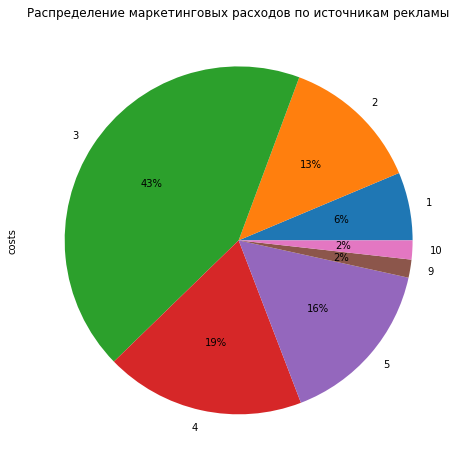

In [76]:
costs_by_source.plot(kind='pie', figsize=(8, 8), autopct='%1.f%%')
plt.title('Распределение маркетинговых расходов по источникам рекламы')
plt.show()

Как изменялись затраты во времени.

In [77]:
costs['first_orders_month'] = costs['dt'].astype('datetime64[M]')

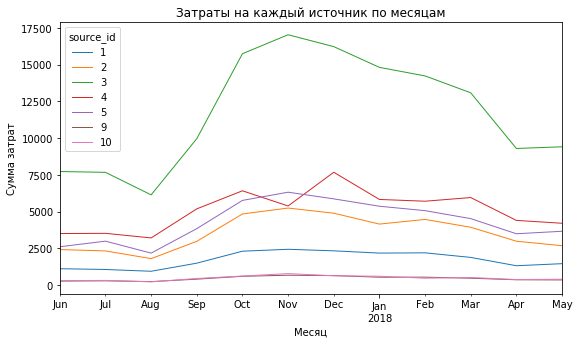

In [78]:
costs.pivot_table(index='source_id', 
                  columns='first_orders_month', 
                  values='costs', 
                  aggfunc='sum'
                 ).T.plot(linewidth = 1, figsize=(9, 5))

plt.ylabel('Сумма затрат')
plt.xlabel('Месяц')
plt.title('Затраты на каждый источник по месяцам')
plt.show()

Самые большие расходы приходятся на 3 источник: 43% от общей суммы. С большим отрывом следует группа из источников 2, 4, 5 со схожими показателями между собой: от 19 до 13%.В последнюю группу входят источники 1, 9, 10 - на них тратится менее 7%.
График изменения затрат во времени показывает, что с сентября 2017 года в источник 3 стали вкладывать очень большие средства.
Также немного увеличи финансирование по источникам 5, 4, 2 также с сентября.

#### Рассчитываем средний CAC на одного покупателя

Посчитаем CAC для всего проекта. Поделим расходы когорт на количество людей в когорте.

Посмотрим на расходы по месяцам.

In [79]:
costs_date = costs.groupby('first_orders_month')['costs'].sum()
costs_date

first_orders_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: costs, dtype: float64

Присоединяем расходы и рассчитываем CAC.

In [80]:
cac_cohorts = ltv_cohorts.groupby('first_orders_month')['uid'].mean().reset_index()
cac_cohorts = cac_cohorts.join(costs_date, on='first_orders_month')
cac_cohorts['cac'] = cac_cohorts['costs'] / cac_cohorts['uid']
cac_cohorts

,first_orders_month,uid,costs,cac
0,2017-06-01,2023,18015.00,8.905091
1,2017-07-01,1923,18240.59,9.485486
2,2017-08-01,1370,14790.54,10.796015
3,2017-09-01,2581,24368.91,9.441654
4,2017-10-01,4340,36322.88,8.369327
5,2017-11-01,4081,37907.88,9.288870
6,2017-12-01,4383,38315.35,8.741809
7,2018-01-01,3373,33518.52,9.937302
8,2018-02-01,3651,32723.03,8.962758
9,2018-03-01,3533,30415.27,8.608907


In [81]:
total_avg_cac = cac_cohorts['cac'].mean()
print('Cредний CAC на одного покупателя {:.2f}'.format(total_avg_cac))

Cредний CAC на одного покупателя 9.15


**Вывод**

Выяснили, что в среднем на одного покупателя уходит 9,15 у.е. маркетинговых расходов. Это больше, чем средний показатель LTV за 6 месяцев. Выглядит, как убыточная ситуация, необходимо развернуть расходы по источникам и найти тот, который не возвращает вложенных средств.

### Рассчитываем средний CAC на одного покупателя для каждого источника трафика.

Найдем первый источник для каждого юзера по первому заходу на сайт.

In [82]:
first_visit_date = first_visit_date.reset_index()

In [83]:
all_sources = visits.loc[:, 'source id': 'uid']

In [84]:
all_sources

,source id,start ts,uid
0,4,2017-12-20 17:20:00,16879256277535980062
1,2,2018-02-19 16:53:00,104060357244891740
2,5,2017-07-01 01:54:00,7459035603376831527
3,9,2018-05-20 10:59:00,16174680259334210214
4,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...
359395,2,2017-07-29 19:07:00,18363291481961487539
359396,1,2018-01-25 17:38:00,18370831553019119586
359397,4,2018-03-03 10:12:00,18387297585500748294
359398,5,2017-11-02 10:12:00,18388616944624776485


Присоединим к таблице с юзерами и датами первых посещений столбец с источником. Благодаря тому, что присоединяем по первой дате, присоединится и самый первый источник.

In [85]:
first_sourse = first_visit_date.merge(all_sources, left_on=['first_visit_date', 'uid'], right_on=['start ts', 'uid'])

In [86]:
first_sourse

,uid,first_visit_date,source id,start ts
0,11863502262781,2018-03-01 17:27:00,3,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00,2,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00,3,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00,2,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00,5,2017-09-30 14:29:00
...,...,...,...,...
228165,18446403737806311543,2017-11-30 03:36:00,5,2017-11-30 03:36:00
228166,18446424184725333426,2017-12-06 20:32:00,4,2017-12-06 20:32:00
228167,18446556406699109058,2018-01-01 16:29:00,3,2018-01-01 16:29:00
228168,18446621818809592527,2017-12-27 13:27:00,4,2017-12-27 13:27:00


Нашли для каждого посетителя первый источник, присоединим этот столбец к датафрейму orders.

In [87]:
first_sourse = first_sourse.rename(columns={'source id':'first_source'}).drop(columns = ['start ts', 'first_visit_date']) #переименуем и удалим лишнее

In [88]:
orders = orders.merge(first_sourse, how='left', left_on='uid', right_on='uid')

In [89]:
orders #проверка

,buy ts,revenue,uid,first_orders_date,first_orders_month,orders_month,lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,3


Найдем расходы по когортам и источникам.

In [90]:
costs_by_sources = costs.groupby(['first_orders_month','source_id']).agg({'costs':'sum'}).reset_index() 
costs_by_sources # расходы по когортам и источникам

,first_orders_month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


Найдем кол-во покупателей по когортам и источникам.

In [91]:
sizes_sources = orders.groupby(['first_orders_month', 'first_source']).agg({'uid': 'nunique'}).reset_index()
sizes_sources # кол-во покупателей по источникам

,first_orders_month,first_source,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


Соединим расходы и кол-во покупателей

In [92]:
costs_by_sources = costs_by_sources.merge(sizes_sources, left_on=['first_orders_month', 'source_id'], right_on=['first_orders_month', 'first_source'])

In [93]:
costs_by_sources

,first_orders_month,source_id,costs,first_source,uid
0,2017-06-01,1,1125.61,1,190
1,2017-06-01,2,2427.38,2,235
2,2017-06-01,3,7731.65,3,638
3,2017-06-01,4,3514.80,4,413
4,2017-06-01,5,2616.12,5,384
...,...,...,...,...,...
79,2018-05-01,3,9411.42,3,844
80,2018-05-01,4,4214.21,4,804
81,2018-05-01,5,3669.56,5,497
82,2018-05-01,9,362.17,9,60


Группировка по когортам, источнику

In [94]:
cac_by_sources = costs_by_sources.groupby('first_source').agg({'uid':'sum', 'costs':'sum'}).reset_index()

In [95]:
cac_by_sources

,first_source,uid,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10295,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


Считаем CAC для одного покупателя по источникам.

In [96]:
cac_by_sources['cac'] = cac_by_sources['costs'] / cac_by_sources['uid']

In [97]:
cac_by_sources # средний CAC в разрезе источников

,first_source,uid,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10295,61073.60,5.932356
4,5,6931,51757.10,7.467479
5,9,1088,5517.49,5.071222
6,10,1329,5822.49,4.381106


In [98]:
cac_by_sources_clean = cac_by_sources.loc[0:, ['first_source', 'cac']]

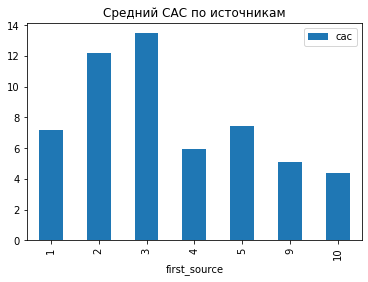

In [99]:
cac_by_sources_clean.plot(kind='bar', x='first_source')
plt.title('Средний CAC по источникам')
plt.show()

In [100]:
costs_by_sources['cac'] = costs_by_sources['costs'] / costs_by_sources['uid']

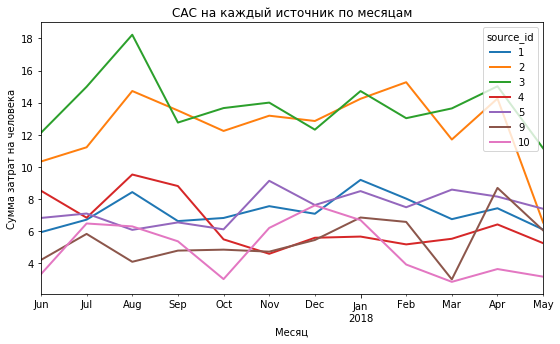

In [101]:
costs_by_sources.pivot_table(index='source_id', 
                  columns='first_orders_month', 
                  values='cac', 
                  aggfunc='sum'
                 ).T.plot(linewidth = 2, figsize=(9, 5))

plt.ylabel('Сумма затрат на человека')
plt.xlabel('Месяц')
plt.title('CAC на каждый источник по месяцам')
plt.show()

**Вывод**
Самые большие затраты на привлечение одного покупателя идут в источники 3 и 2. Это лидеры. Средние затраты идут на источники 1 и 5, там около 7 у.е. уходит в среднем на привлечение одного покупателя. Остальные источники показывают самые маленькие затраты - менее 7.
Интересно, что CAC 3 самого затратного источника снизился в сентябре, как раз тогда, когда общие рекламные расходы на него возросли. Значит, реклама принесла свои плоды и привлекла дополнительную аудиторию.
CAC источника 4 тоже снизились на фоне повышения рекламных расходов, значит тут тоже сработал маркетинг.
А вот с источником 2 проблема. Расходы подняли, но CAC нестабилен и сильно скачет. Нужно разобраться. 

Взглянем на окупаемость.


### ROMI по когортам в разрезе источников. 

In [102]:
orders.head(10)

,buy ts,revenue,uid,first_orders_date,first_orders_month,orders_month,lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01,0,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,0,5
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,4
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01,2017-06-01,0,1


Сгруппируем заказы по когортам и источникам. Присоединим датафрейм с затратами и источниками.

In [103]:
romi_cohorts = orders.groupby(['first_orders_month', 'first_source']).agg({'revenue':'sum'}).reset_index()
romi_cohorts_2 = romi_cohorts.merge(costs_by_sources, left_on=['first_source', 'first_orders_month'], right_on=['first_source', 'first_orders_month'])

Рассчитаем метрики LTV, CAC и ROMI по когортам в разрезе источников

In [104]:
romi_cohorts_2['ltv'] = romi_cohorts_2['revenue'] / romi_cohorts_2['uid']
romi_cohorts_2['cac'] = romi_cohorts_2['costs'] / romi_cohorts_2['uid']
romi_cohorts_2['romi'] = romi_cohorts_2['ltv'] / romi_cohorts_2['cac']
romi_cohorts_2

,first_orders_month,first_source,revenue,source_id,costs,uid,cac,ltv,romi
0,2017-06-01,1,6392.39,1,1125.61,190,5.924263,33.644158,5.679045
1,2017-06-01,2,3915.26,2,2427.38,235,10.329277,16.660681,1.612957
2,2017-06-01,3,3640.32,3,7731.65,638,12.118574,5.705831,0.470834
3,2017-06-01,4,4992.67,4,3514.80,413,8.510412,12.088789,1.420471
4,2017-06-01,5,4377.64,5,2616.12,384,6.812813,11.400104,1.673333
...,...,...,...,...,...,...,...,...,...
79,2018-05-01,3,3256.54,3,9411.42,844,11.150972,3.858460,0.346020
80,2018-05-01,4,3802.91,4,4214.21,804,5.241555,4.729988,0.902402
81,2018-05-01,5,2094.04,5,3669.56,497,7.383421,4.213360,0.570652
82,2018-05-01,9,223.05,9,362.17,60,6.036167,3.717500,0.615871


In [105]:
romi_cohorts_2_pivot = romi_cohorts_2.pivot_table(index='first_orders_month', columns='first_source', values='romi', aggfunc='sum')

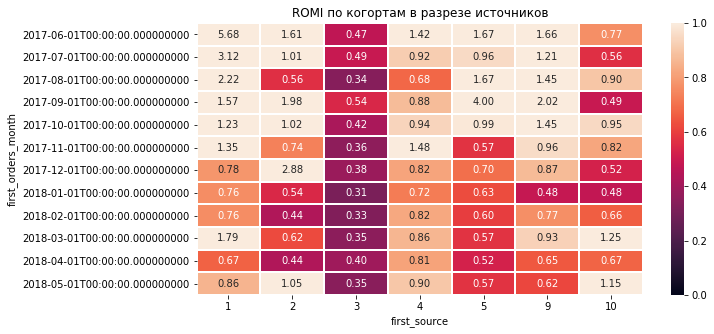

In [106]:
plt.figure(figsize=(10, 5))
plt.title('ROMI по когортам в разрезе источников')
sns.heatmap(romi_cohorts_2_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0.0, vmax=1)
plt.show()

Как видно на графике, источник 3 не окупился ни в одной из когорт - все ячейки темного цвета, а значит, не дотягивают до предельного значения в единицу.
Для чистоты данных обратимся только к тем когортам, которые прожили не менее 6 месяцев, возьмем период в 6 месяцев.

### Окупаемость за одинаковые периоды жизни когорт.

In [107]:
romi_cohorts3 = orders[(orders['first_orders_month'] < '2018-01-01') & (orders['lifetime'] < 6)] #срез

In [108]:
romi_cohorts4 = romi_cohorts3.groupby(['first_orders_month', 'first_source']).agg({'revenue':'sum'}).reset_index() #группировка по когорте и источнику

In [109]:
romi_cohorts4 = romi_cohorts4.merge(costs_by_sources, left_on=['first_source', 'first_orders_month'], right_on=['first_source', 'first_orders_month']) 
# мерджим с затратами

In [110]:
romi_cohorts4.head()

,first_orders_month,first_source,revenue,source_id,costs,uid,cac
0,2017-06-01,1,4127.89,1,1125.61,190,5.924263
1,2017-06-01,2,2283.13,2,2427.38,235,10.329277
2,2017-06-01,3,3435.55,3,7731.65,638,12.118574
3,2017-06-01,4,3326.02,4,3514.80,413,8.510412
4,2017-06-01,5,3122.32,5,2616.12,384,6.812813


In [111]:
#расчеты метрик
romi_cohorts4['ltv'] = romi_cohorts4['revenue'] / romi_cohorts4['uid']
romi_cohorts4['cac'] = romi_cohorts4['costs'] / romi_cohorts4['uid']
romi_cohorts4['romi'] = romi_cohorts4['ltv'] / romi_cohorts4['cac']

In [112]:
romi_cohorts4_pivot = romi_cohorts4.pivot_table(index='first_orders_month', columns='first_source', values='romi', aggfunc='sum')
romi_cohorts4_pivot.round(2)

first_source,1,2,3,4,5,9,10
first_orders_month,,,,,,,
2017-06-01,3.67,0.94,0.44,0.95,1.19,1.32,0.77
2017-07-01,2.54,0.91,0.47,0.87,0.91,1.06,0.56
2017-08-01,1.47,0.52,0.32,0.63,1.49,1.29,0.87
2017-09-01,1.43,1.63,0.51,0.70,3.93,1.57,0.49
2017-10-01,1.16,0.99,0.41,0.91,0.95,1.44,0.93
2017-11-01,1.34,0.73,0.35,1.43,0.56,0.96,0.81
2017-12-01,0.78,2.88,0.38,0.82,0.70,0.87,0.52


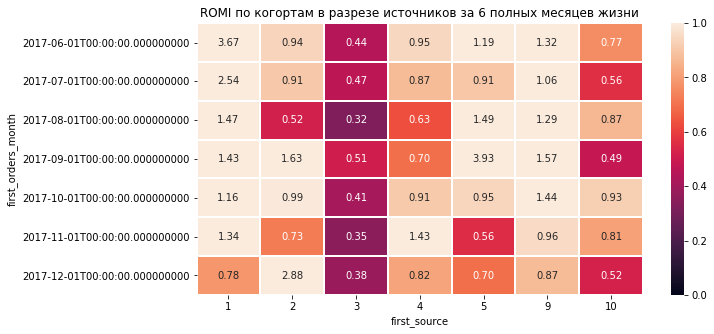

In [113]:
plt.figure(figsize=(10, 5))
plt.title('ROMI по когортам в разрезе источников за 6 полных месяцев жизни')
sns.heatmap(romi_cohorts4_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0.0, vmax=1)
plt.show()

Самые прибыльные источники - это 1 и 9, они окупаются лучше всего во всех выбранных когортах за полгода.
Хорошие показатели у источников 2, 4, в некоторых когортах они являются лидерами по окупаемости, нужно понять, зависит ли это от сезонности и как можно увеличить поток с этих источников.

Стоит обратить внимание на падение показателей окупаемости источника 5, в сентябрьской когорте он был самым прибыльным, а потом результаты ухудшились.

Источники 3 и 10 не окупились ни в одной когорте за полгода. Хотя у 10 есть показатели, близкие к 1, возможно просто нужно больше времени. А вот 3 показыает худшие результаты. Это самый убыточный источник.

## Вывод.<a name="paragraph4"></a>

**Источники.** Расчет среднего CAC на одного покупателя показал, что большая часть средств уходить на привлечение покупателей через источники 2 и 3, но рассчитав ROMI мы увидели, что у источника №3 не было окупаемости ни в одной из когорт. Необходимо пересмотреть расходы на него.
Стоит проанализировать падение окупаемости источника 5, показатели у него ухудшились в более молодых когортах. 

Перераспредление рекламного бюджета можно пустить на источник 4, у него невысокий средний CAC, но есть перспективы окупаемости, судя по прошлым месяцам.
Самым перспективными является источник 1 и 9, стабильно положительный ROMI почти во всех когортах.

**Анализ метрик** показал, что чаще всего люди заходят на сервис в осенне-зимний период, пиковая неделя и день приходится на черную пятницу, что ожидаемо. Также высокая посещаемость у декабря. 
Был обнаружен день с рекордно-низким показателем в одно посещение - 31.03.2018. Необходимо выявить причины сбоя. 

Половина всех покупок совершается за 16 мин от первого посещения, пользователи заходят на сервис с конкретной целью или по прямой рекламе. Другая часть покупателей - более медленных - тратят больше времени (дни и недели), ожидая снижения цен или появления более интересного события.

**Когорты.** Retention Rate на второй месяц дает средний результат возвратов в 6,52% покупателей от общего изначального числа. Далее показатель снижается до 4-2%. Самые высокие показатели возвратов у декабрьской когорты.Также декабрьская когорта демонстрирует отличные результаты по накапливаемости LTV и среднему чеку. Это самая персективная когорта. Хорошие показатели LTV и среднего чека у сентябрьской когорты. Стоит также обратить внимание на ее перспективы. 
